### We take images from healthy and unhealthy people to try and see if we can visualize what anomalies may look like

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os

In [160]:
model_path = '/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/CNN-segmentation/logdir/inference_results/unet3d_da_0.0nchannels4_r1_loss_dice_cut_z_False_full_run_only_w_labels_e80_lr_1e-3_AdamW_val_40'

In [161]:
os.listdir(model_path)

# Load data
control_data = h5py.File(os.path.join(model_path, 'controls_masked_sliced_images.hdf5'), 'r')
patient_data = h5py.File(os.path.join(model_path, 'patients_masked_sliced_images.hdf5'), 'r')
control = control_data['sliced_images_controls'][:]
patient = patient_data['sliced_images_patients'][:320]
# We take 5 control and 5 patient images
print(control.shape, patient.shape)
# Reshaping to patients 
control = control.reshape(-1, 64, 32, 32, 48, 4)
patient = patient.reshape(5, 64, 32, 32, 48, 4)
print(control.shape, patient.shape)

(1792, 32, 32, 48, 4) (320, 32, 32, 48, 4)
(28, 64, 32, 32, 48, 4) (5, 64, 32, 32, 48, 4)


[Case 1](#case-1)

## Case 1
- Take midpoint in ascending aorta (slice 32)
- Take time at which velocity magnitude is highest
- Take velocity magnitude channel

In [173]:
# Pick midpoint ascending aorta # index 32 ? 
control_mid = control[:, 32, ...]
patient_mid = patient[:, 32, ...]
print(control_mid.shape, patient_mid.shape)

# Compute velocity magnitude
control_mid = np.concatenate((control_mid, np.linalg.norm(control_mid[...,1:], axis=-1, keepdims=True)), axis=-1)
patient_mid = np.concatenate((patient_mid, np.linalg.norm(patient_mid[...,1:], axis=-1, keepdims=True)), axis=-1)
print(control_mid.shape, patient_mid.shape)


(28, 32, 32, 48, 4) (5, 32, 32, 48, 4)
(28, 32, 32, 48, 5) (5, 32, 32, 48, 5)


In [174]:
# Pick time index with highest velocity mangitude
max_magnitude_control_mid = abs(control_mid[...,4]).max(axis=(1,2))
max_magnitude_patient_mid = abs(patient_mid[...,4]).max(axis=(1,2))
print(max_magnitude_control_mid.shape, max_magnitude_patient_mid.shape)
print(max_magnitude_control_mid.argmax(axis=1), max_magnitude_patient_mid.argmax(axis=1))

(28, 48) (5, 48)
[6 4 5 3 4 4 4 3 3 3 3 4 3 5 3 3 3 4 4 4 3 4 3 3 3 3 3 3] [2 4 4 4 3]


In [175]:
control_mid_t = np.array([control_mid[i, :, :,max_magnitude_control_mid.argmax(axis=1)[i],:] for i in range(control_mid.shape[0])])
patient_mid_t = np.array([patient_mid[i, :, :,max_magnitude_patient_mid.argmax(axis=1)[i],:] for i in range(patient_mid.shape[0])])

print(control_mid_t.shape, patient_mid_t.shape)

(28, 32, 32, 5) (5, 32, 32, 5)


Control on top, patient on bottom


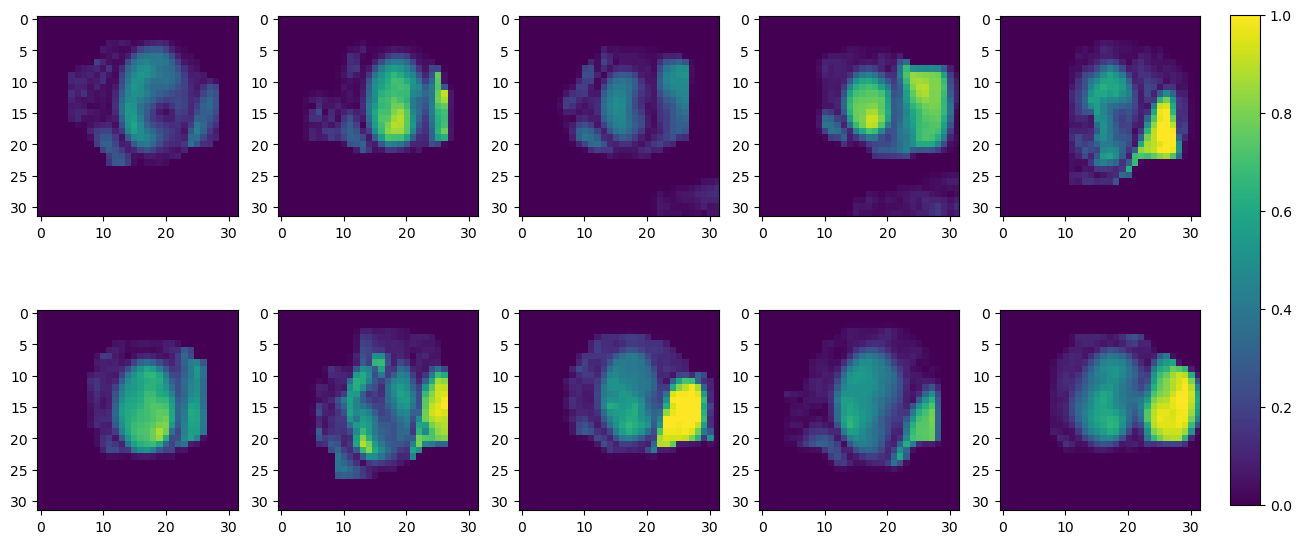

In [176]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 7))

cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar as needed

for i in range(5):
    im0 = axes[0, i].imshow(control_mid_t[i, ..., 4], cmap = 'viridis', vmin = 0, vmax = 1)
    im1 = axes[1, i].imshow(patient_mid_t[i, ..., 4], cmap = 'viridis', vmin = 0, vmax = 1)

# Add a colorbar to the right side
fig.colorbar(im1, cax=cbar_ax)

print('Control on top, patient on bottom')
plt.show()


Text(0.5, 0.01, 'Time ')

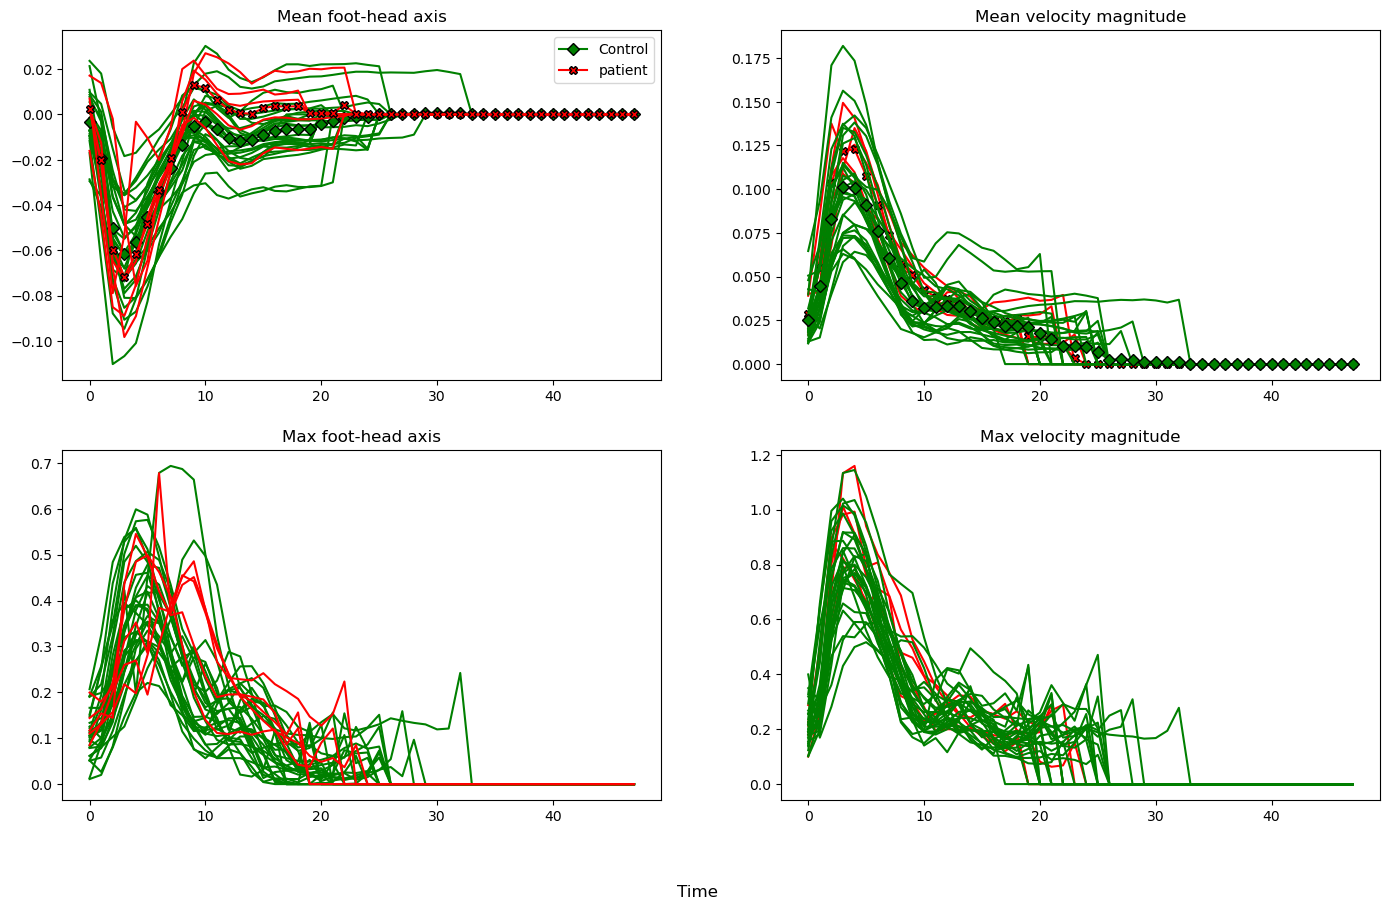

In [177]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 10))


ax[0, 0].plot(control_mid[ ..., 1].mean(axis = (1,2)).T, color = "green");
ax[0, 0].plot(control_mid[ ..., 1].mean(axis = (0,1,2)).T, color = "green", marker = 'D', markeredgecolor = 'black', label = 'Control');
ax[0,0].set_title('Mean foot-head axis')
ax[0, 0].plot(patient_mid[ ..., 1].mean(axis = (1,2)).T, color = "red");
ax[0, 0].plot(patient_mid[ ..., 1].mean(axis = (0,1,2)).T, color = "red", marker = 'X', markeredgecolor = 'black', label = 'patient');
ax[0, 0].legend()
ax[1, 0].plot(control_mid[ ..., 1].max(axis = (1,2)).T, color = "green");
ax[1,0].set_title('Max foot-head axis')
ax[1, 0].plot(patient_mid[ ..., 1].max(axis = (1,2)).T, color = "red");
ax[0,1].set_title('Mean velocity magnitude')
ax[0, 1].plot(patient_mid[ ..., 4].mean(axis = (1,2)).T, color = "red");
ax[0,1].plot(patient_mid[ ..., 4].mean(axis = (0,1,2)).T, color = "red", marker = 'X', markeredgecolor = 'black');
ax[0, 1].plot(control_mid[ ..., 4].mean(axis = (1,2)).T, color = "green");
ax[0,1].plot(control_mid[ ..., 4].mean(axis = (0,1,2)).T, color = "green", marker = 'D', markeredgecolor = 'black');
ax[1,1].set_title('Max velocity magnitude')
ax[1, 1].plot(patient_mid[ ..., 4].max(axis = (1,2)).T, color = "red");
ax[1, 1].plot(control_mid[ ..., 4].max(axis = (1,2)).T, color = "green");
fig.supxlabel('Time ')



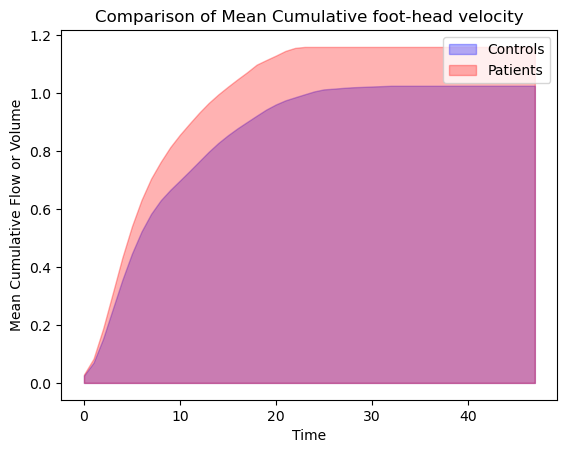

In [9]:
# Compute the cumulative flow or volume over time for controls and patients
cumulative_flow_controls = np.cumsum(control_mid[...,4], axis=3)
cumulative_flow_patients = np.cumsum(patient_mid[...,4], axis=3)

# Generate the x-axis values (time points)
time_points = np.arange(control_mid.shape[3])

# Compute the mean cumulative flow or volume across spatial dimensions (patient, x, y)
mean_cumulative_flow_controls = np.mean(cumulative_flow_controls, axis=(0, 1, 2))
mean_cumulative_flow_patients = np.mean(cumulative_flow_patients, axis=(0, 1, 2))
# Create the area chart for controls
plt.fill_between(time_points, mean_cumulative_flow_controls, color='blue', alpha=0.3, label='Controls')

# Create the area chart for patients
plt.fill_between(time_points, mean_cumulative_flow_patients, color='red', alpha=0.3, label='Patients')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Mean Cumulative Flow or Volume')
plt.title('Comparison of Mean Cumulative foot-head velocity')
plt.legend()

# Display the plot
plt.show()


## Case 2
- Take a range of values out of 64, why not 20:44 ()

In [178]:
# Pick range in ascending aorta 
control_range = control[:, 20:44, ...]
patient_range = patient[:, 20:44, ...]
print(control_range.shape, patient_range.shape)
# Compute velocity magnitude
control_range = np.concatenate((control_range, np.linalg.norm(control_range[...,1:], axis=-1, keepdims=True)), axis=-1)
patient_range = np.concatenate((patient_range, np.linalg.norm(patient_range[...,1:], axis=-1, keepdims=True)), axis=-1)
print(control_range.shape, patient_range.shape)

(28, 24, 32, 32, 48, 4) (5, 24, 32, 32, 48, 4)
(28, 24, 32, 32, 48, 5) (5, 24, 32, 32, 48, 5)


In [179]:
# Pick time index with highest velocity mangitude
max_magnitude_control_range = abs(control_range[...,4]).max(axis=(1,2,3))
max_magnitude_patient_range = abs(patient_range[...,4]).max(axis=(1,2,3))
print(max_magnitude_control_range.shape, max_magnitude_patient_range.shape)
print(max_magnitude_control_range.argmax(axis=1), max_magnitude_patient_range.argmax(axis=1))

(28, 48) (5, 48)
[5 4 4 3 4 4 4 3 4 3 3 5 3 5 3 4 3 4 4 4 3 4 3 3 4 3 3 3] [3 3 4 4 4]


In [180]:
control_range_t = np.array([control_range[i, :, :,:,max_magnitude_control_range.argmax(axis=1)[i],:] for i in range(control_range.shape[0])])
patient_range_t = np.array([patient_range[i, :, :,:,max_magnitude_patient_range.argmax(axis=1)[i],:] for i in range(patient_range.shape[0])])

print(control_range_t.shape, patient_range_t.shape)

(28, 24, 32, 32, 5) (5, 24, 32, 32, 5)


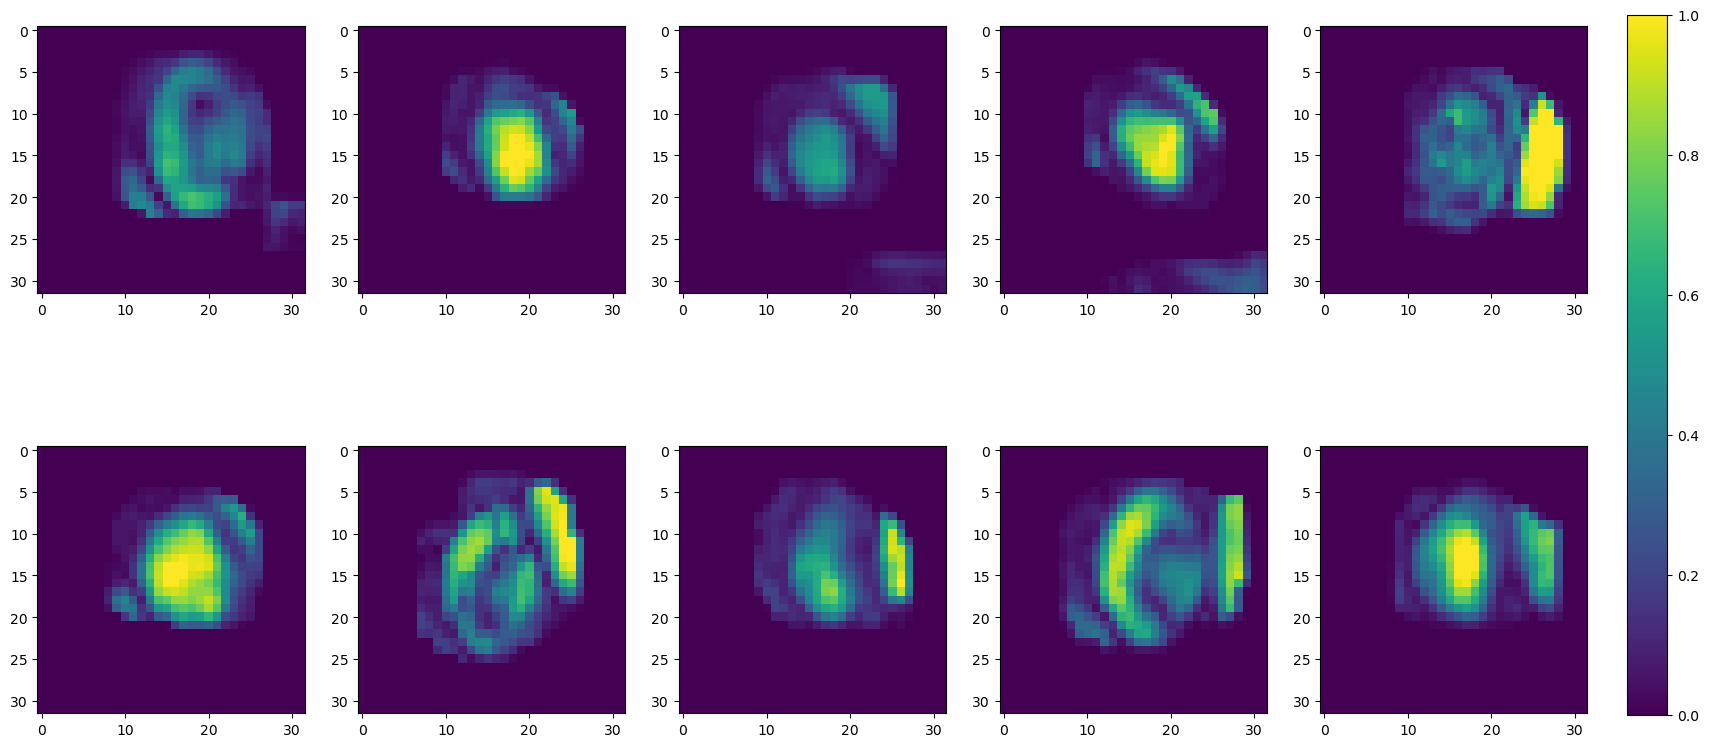

In [185]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar as needed

c_ = 4
if c_ == 4:
    vmin = 0
    vmax = 1
else:
    vmin = -1
    vmax = 1
for i in range(5):
    im0 = axes[0, i].imshow(control_range_t[i,0, ..., c_], vmin = vmin, vmax = vmax)
    im1 = axes[1, i].imshow(patient_range_t[i,0, ..., c_], vmin = vmin, vmax = vmax)

# Add a colorbar to the right side
fig.colorbar(im1, cax=cbar_ax)

plt.show()

In [14]:
control_range.shape

(28, 24, 32, 32, 48, 5)

Text(0.5, 0.01, 'Time ')

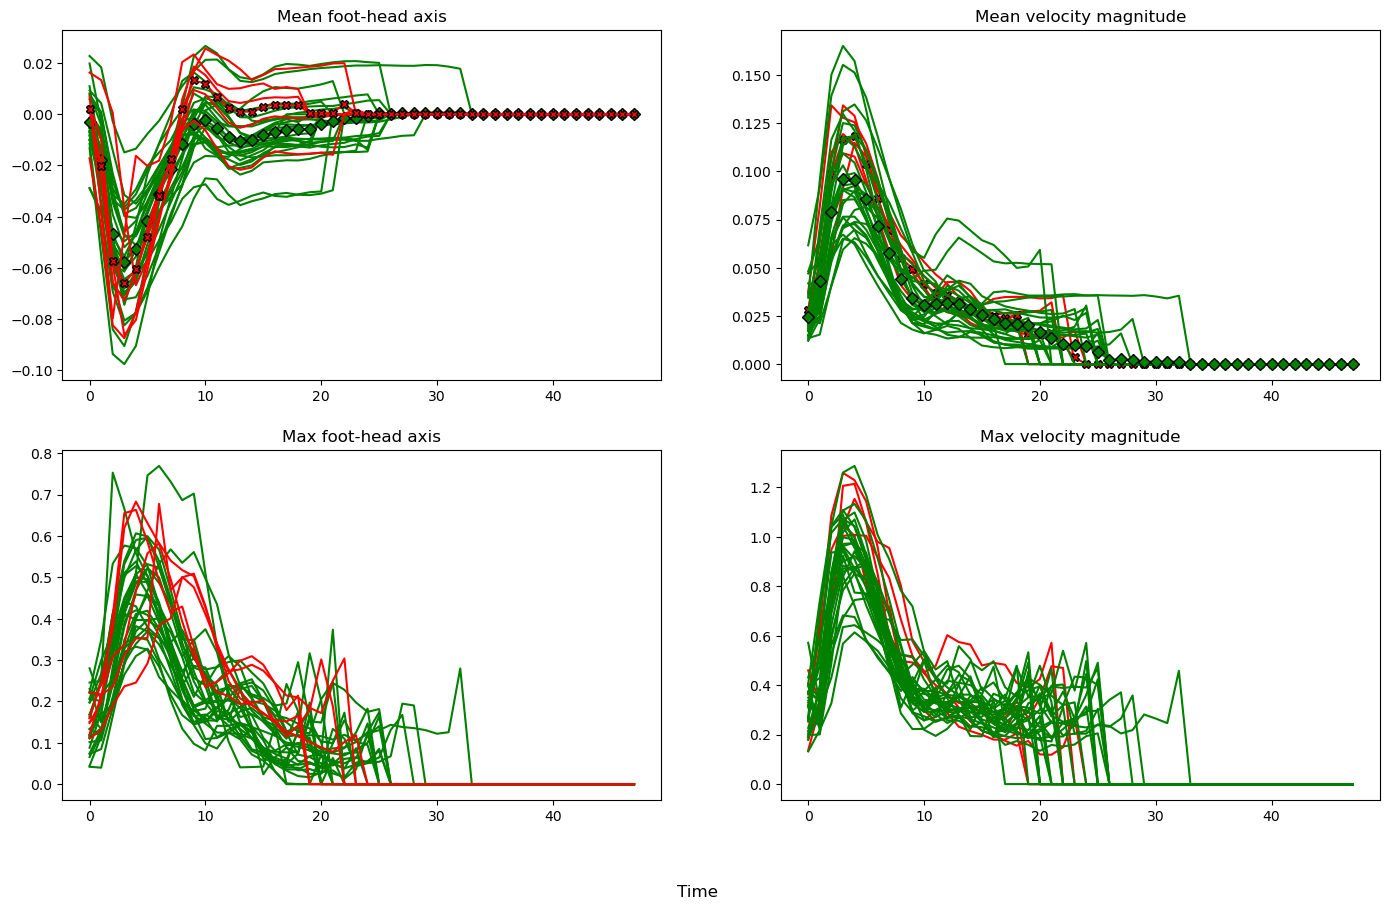

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 10))


ax[0, 0].plot(control_range[ ..., 1].mean(axis = (1,2,3)).T, color = "green", );
ax[0,0].plot(control_range[ ..., 1].mean(axis = (0,1,2,3)).T, color = "green", marker = 'D', markeredgecolor = 'black');
ax[0,0].set_title('Mean foot-head axis')
ax[0, 0].plot(patient_range[ ..., 1].mean(axis = (1,2,3)).T, color = "red");
ax[0, 0].plot(patient_range[ ..., 1].mean(axis = (0,1,2,3)).T, color = "red", marker = 'X', markeredgecolor = 'black');
ax[1, 0].plot(control_range[ ..., 1].max(axis = (1,2,3)).T, color = "green");
ax[1,0].set_title('Max foot-head axis')
ax[1, 0].plot(patient_range[ ..., 1].max(axis = (1,2,3)).T, color = "red");
ax[0,1].set_title('Mean velocity magnitude')
ax[0, 1].plot(patient_range[ ..., 4].mean(axis = (1,2,3)).T, color = "red");
ax[0,1].plot(patient_range[ ..., 4].mean(axis = (0,1,2,3)).T, color = "red", marker = 'X', markeredgecolor = 'black');
ax[0, 1].plot(control_range[ ..., 4].mean(axis = (1,2,3)).T, color = "green");
ax[0,1].plot(control_range[ ..., 4].mean(axis = (0,1,2,3)).T, color = "green", marker = 'D', markeredgecolor = 'black');
ax[1,1].set_title('Max velocity magnitude')
ax[1, 1].plot(patient_range[ ..., 4].max(axis = (1,2,3)).T, color = "red");
ax[1, 1].plot(control_range[ ..., 4].max(axis = (1,2,3)).T, color = "green");
fig.supxlabel('Time ')


## Case 3:

- Visualize through and through the slices 

In [187]:
# Compute magnitude 
control = np.concatenate((control, np.linalg.norm(control[...,1:], axis=-1, keepdims=True)), axis=-1)
patient = np.concatenate((patient, np.linalg.norm(patient[...,1:], axis=-1, keepdims=True)), axis=-1)
control.shape, patient.shape

((28, 64, 32, 32, 48, 5), (5, 64, 32, 32, 48, 5))

t = 4 z = 0 c = 1


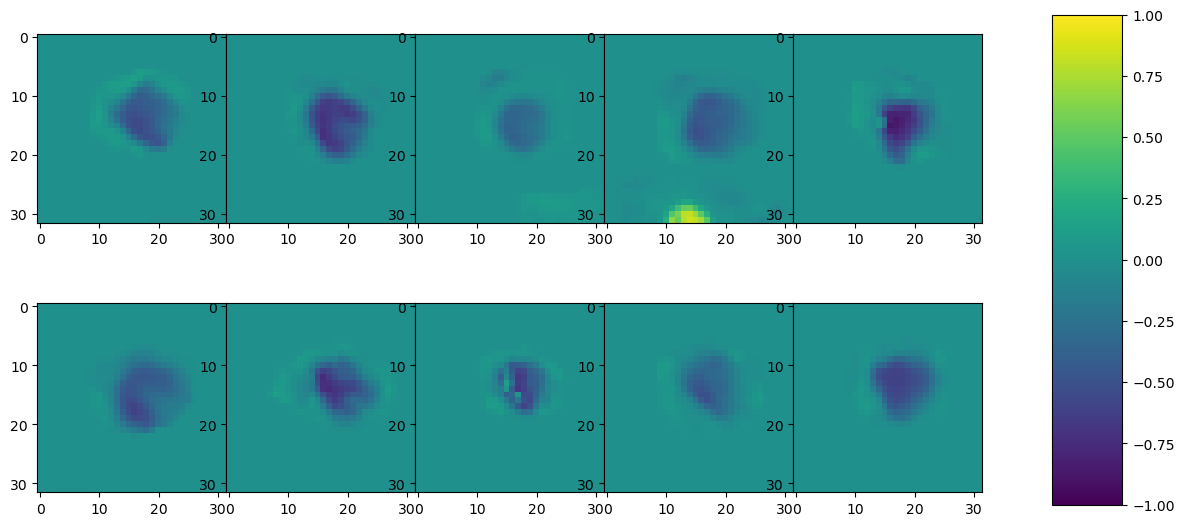

In [237]:
z = 0
#t = 0
c = 1

if c == 4:
    vmin = 0
    vmax = 1.3
else:
    vmin = -1
    vmax = 1
print('t =', t, 'z =', z, 'c =', c)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
im = axes[0,0].imshow(control[0, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,1].imshow(control[1, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,2].imshow(control[2, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,3].imshow(control[3, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,4].imshow(control[4, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,0].imshow(patient[0, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,1].imshow(patient[1, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,2].imshow(patient[2, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,3].imshow(patient[3, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,4].imshow(patient[4, z, :,:,t,c], vmin = vmin, vmax = vmax)
t +=1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


#plt.colorbar()
plt.subplots_adjust(wspace=0, hspace=0)


## Case 4

- Plot

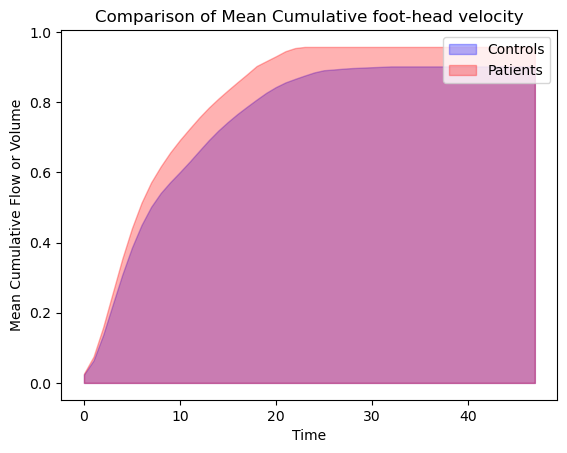

In [238]:
# Assuming you have loaded your flow data for controls and patients
flow_data_controls = control[:,:,:,:,:,4]  
flow_data_patients = patient[:,:,:,:,:,4] 
# Compute the cumulative flow or volume over time for controls and patients
cumulative_flow_controls = np.cumsum(flow_data_controls, axis=4)
cumulative_flow_patients = np.cumsum(flow_data_patients, axis=4)

# Generate the x-axis values (time points)
time_points = np.arange(flow_data_controls.shape[4])

# Compute the mean cumulative flow or volume across spatial dimensions (patient, x, y, z)
mean_cumulative_flow_controls = np.mean(cumulative_flow_controls, axis=(0, 1, 2,3))
mean_cumulative_flow_patients = np.mean(cumulative_flow_patients, axis=(0, 1, 2,3))

# Create the area chart for controls
plt.fill_between(time_points, mean_cumulative_flow_controls, color='blue', alpha=0.3, label='Controls')

# Create the area chart for patients
plt.fill_between(time_points, mean_cumulative_flow_patients, color='red', alpha=0.3, label='Patients')

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Mean Cumulative Flow or Volume')
plt.title('Comparison of Mean Cumulative foot-head velocity')
plt.legend()

# Display the plot
plt.show()


## Case 5

- I want to profile the mean velocity (magnitude ?) through the slices 

Text(0.5, 1.0, 'Max foot-head velocity through Slices')

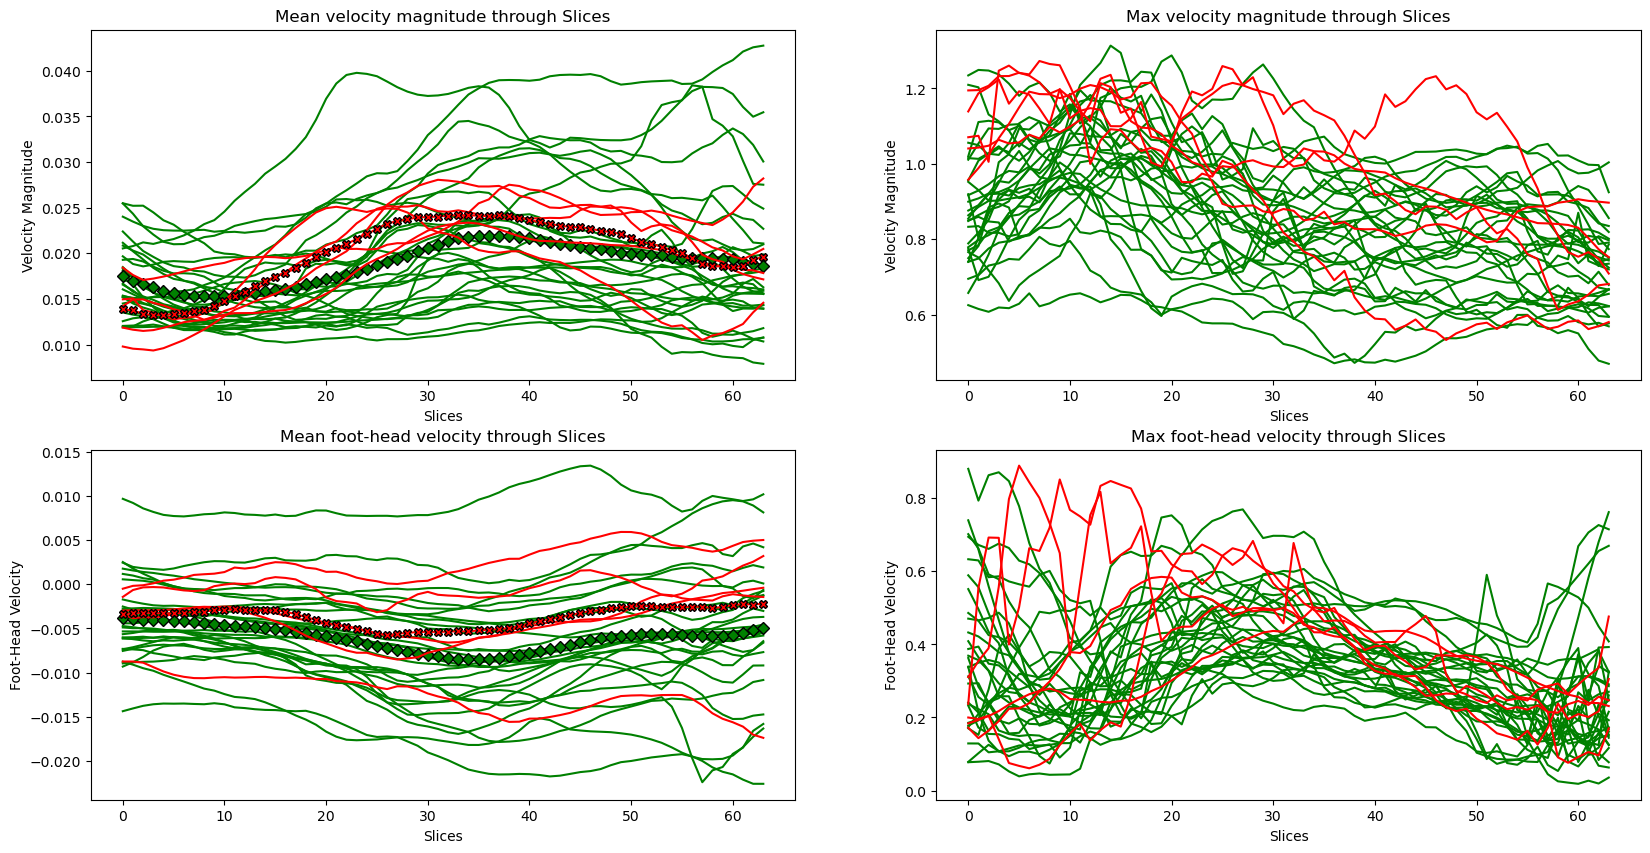

In [239]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax = axes.ravel()
# Create the line plot
ax[0].plot(control[...,4].mean(axis=(2,3,4)).T, label='Controls', color = 'green')
ax[0].plot(control[...,4].mean(axis=(0,2,3,4)).T, label='Controls', color = 'green', marker = 'D', markeredgecolor = 'black')
ax[0].plot(patient[...,4].mean(axis=(2,3,4)).T, label='Patients', color = 'red')
ax[0].plot(patient[...,4].mean(axis=(0,2,3,4)).T, label='Patients', color = 'red', marker = 'X', markeredgecolor = 'black')
ax[0].set_xlabel('Slices')
ax[0].set_ylabel('Velocity Magnitude')
ax[0].set_title('Mean velocity magnitude through Slices')
# Create the line plot
ax[1].plot(np.max(control[...,4],axis=(2,3,4)).T, label='Controls', color = 'green')
ax[1].plot(np.max(patient[...,4],axis=(2,3,4)).T, label='Patients', color = 'red')
ax[1].set_xlabel('Slices')
ax[1].set_ylabel('Velocity Magnitude')
ax[1].set_title('Max velocity magnitude through Slices')

ax[2].plot(control[...,1].mean(axis=(2,3,4)).T, label='Controls', color = 'green')
ax[2].plot(control[...,1].mean(axis=(0,2,3,4)).T, label='Controls', color = 'green', marker = 'D', markeredgecolor = 'black')
ax[2].plot(patient[...,1].mean(axis=(2,3,4)).T, label='Patients', color = 'red')
ax[2].plot(patient[...,1].mean(axis=(0,2,3,4)).T, label='Patients', color = 'red', marker = 'X', markeredgecolor = 'black')
ax[2].set_xlabel('Slices')
ax[2].set_ylabel('Foot-Head Velocity')
ax[2].set_title('Mean foot-head velocity through Slices')

ax[3].plot(control[...,1].max(axis=(2,3,4)).T, label='Controls', color = 'green')
ax[3].plot(patient[...,1].max(axis=(2,3,4)).T, label='Patients', color = 'red')
ax[3].set_xlabel('Slices')
ax[3].set_ylabel('Foot-Head Velocity')
ax[3].set_title('Max foot-head velocity through Slices')


## Case 6

- Acceleration 

In [240]:
control.shape, patient.shape

((28, 64, 32, 32, 48, 5), (5, 64, 32, 32, 48, 5))

In [241]:
desired_slice = None
filtered_control = control[:, :, ...]
filtered_patient = patient[:, :, ...]
print(filtered_control.shape, filtered_patient.shape)
velocity_diff_control = np.diff(filtered_control, axis=4)
velocity_diff_patient = np.diff(filtered_patient, axis=4)
print(velocity_diff_control.shape, velocity_diff_patient.shape)

# Take time 5 - it's where the shoot happens around

velocity_diff_control = velocity_diff_control[...,4,:]
velocity_diff_patient = velocity_diff_patient[...,4,:]
print(velocity_diff_control.shape, velocity_diff_patient.shape)
velocity_diff_control.max(axis=(0,1,2,3)), velocity_diff_patient.max(axis=(0,1,2,3)), velocity_diff_control.min(axis=(0,1,2,3)), velocity_diff_patient.min(axis=(0,1,2,3))


(28, 64, 32, 32, 48, 5) (5, 64, 32, 32, 48, 5)
(28, 64, 32, 32, 47, 5) (5, 64, 32, 32, 47, 5)
(28, 64, 32, 32, 5) (5, 64, 32, 32, 5)


(array([0.0259132 , 0.7418782 , 0.49926776, 0.5341852 , 0.66154253],
       dtype=float32),
 array([0.02507579, 1.2250113 , 0.3387738 , 1.3749654 , 0.75551945],
       dtype=float32),
 array([-0.02841157, -0.683837  , -0.47748688, -1.3226197 , -0.6836395 ],
       dtype=float32),
 array([-0.02539145, -1.3146131 , -0.5110819 , -1.5670837 , -0.7551663 ],
       dtype=float32))

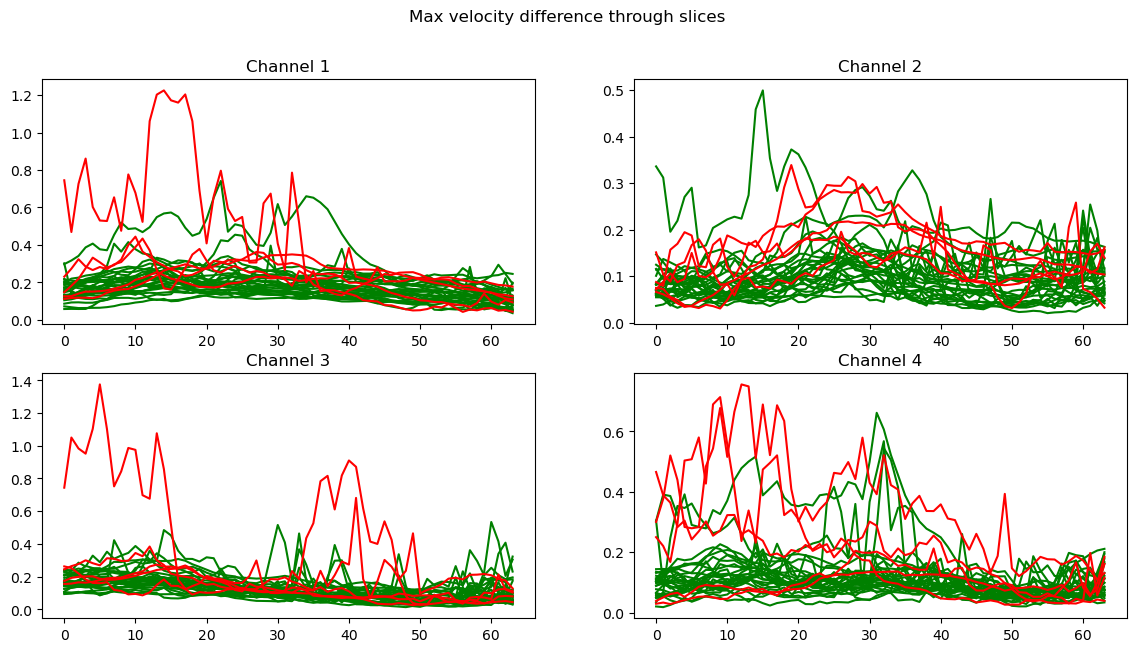

In [242]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
fig.suptitle('Max velocity difference through slices')
axs = axes.ravel()
for i in range(4):
    axs[i].plot(velocity_diff_control[...,i+1].max(axis = (2,3)).T, color = "green");
    axs[i].plot(velocity_diff_patient[...,i+1].max(axis = (2,3)).T, color = "red");
    axs[i].set_title('Channel ' + str(i+1))
plt.show()

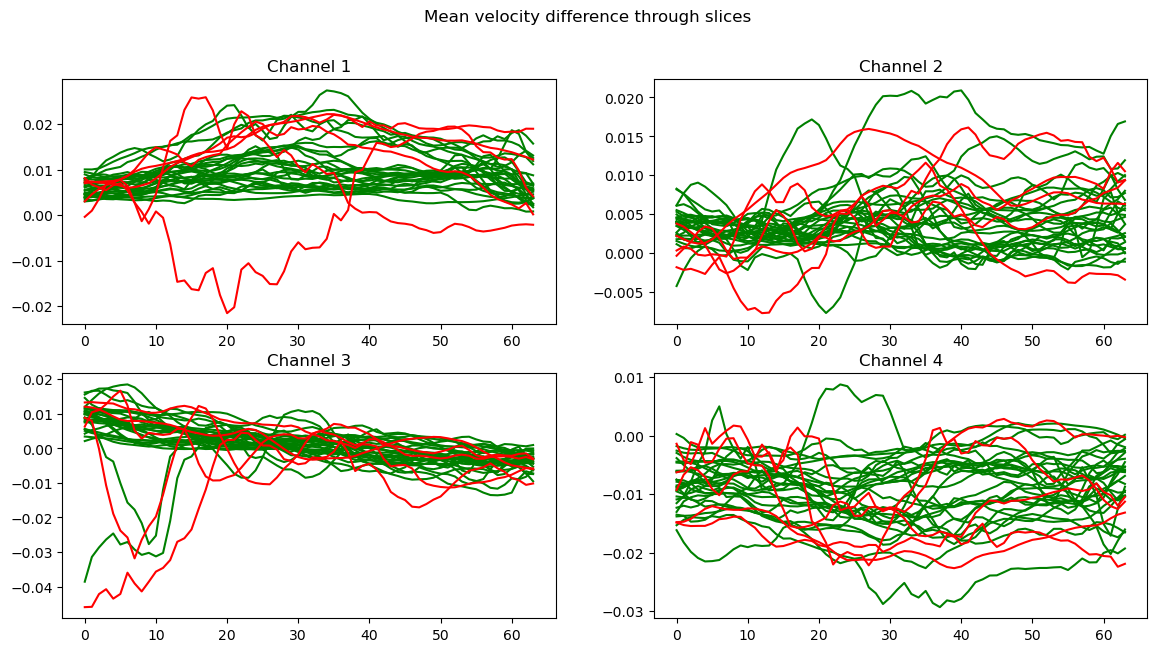

In [243]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
fig.suptitle('Mean velocity difference through slices')
axs = axes.ravel()
for i in range(4):
    axs[i].plot(velocity_diff_control[...,i+1].mean(axis = (2,3)).T, color = "green");
    axs[i].plot(velocity_diff_patient[...,i+1].mean(axis = (2,3)).T, color = "red");
    axs[i].set_title('Channel ' + str(i+1))
plt.show()

TypeError: Invalid shape (64, 32, 32) for image data

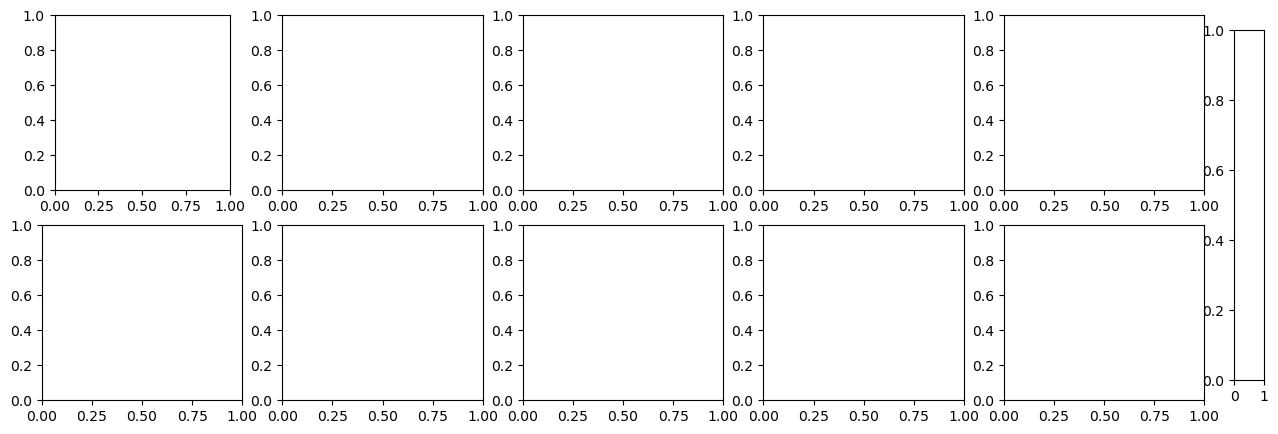

In [244]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position of the colorbar as needed

c_ = 4


for i in range(5):
    im0 = axes[0, i].imshow(velocity_diff_control[i,..., c_])
    im1 = axes[1, i].imshow(velocity_diff_patient[i,..., c_])

t +=1
# Add a colorbar to the right side
fig.colorbar(im1, cax=cbar_ax)
print('Control on top, patient on bottom')
print('c =', c_)
plt.show()

## Case 7

- Take the mean and compute the difference etc 

In [405]:
control_mean = control[:10,...].mean(axis=(0))
rest_control = control[10:]
control_mean.shape, rest_control.shape

((64, 32, 32, 48, 5), (18, 64, 32, 32, 48, 5))

In [406]:
diff_patient = patient - control_mean
diff_control = rest_control - control_mean
diff_patient.shape, diff_control.shape

((5, 64, 32, 32, 48, 5), (18, 64, 32, 32, 48, 5))

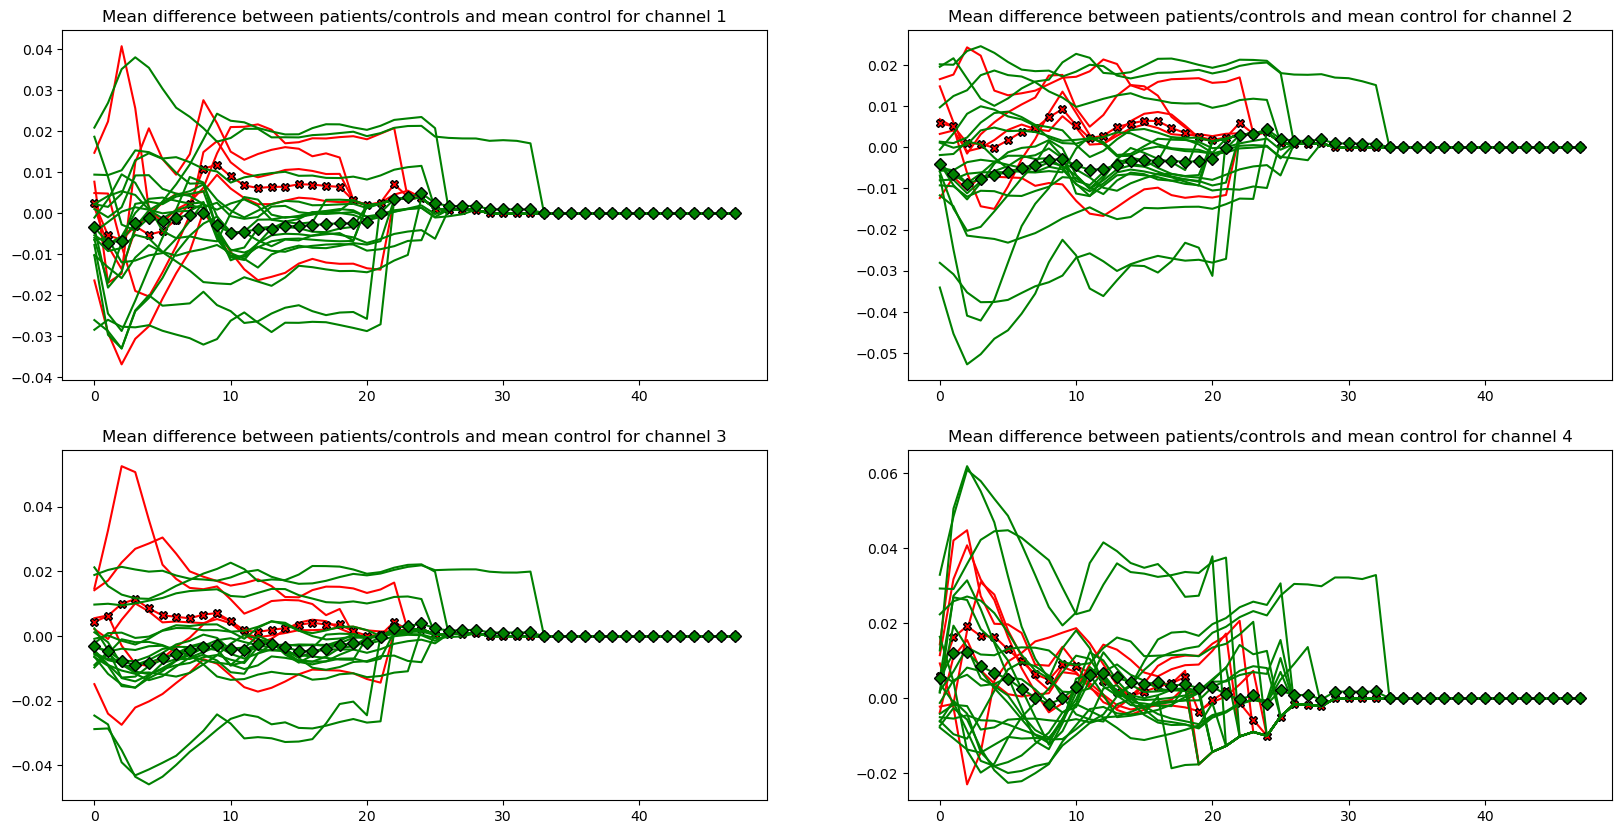

In [407]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
ax = axes.ravel()
for i in range(4):
    
    ax[i].plot(diff_patient[:,:,:,:,:,i+1].mean(axis=(1,2,3)).T, label='Patients', color = 'red');
    ax[i].plot(diff_patient[:,:,:,:,:,i+1].mean(axis=(0,1,2,3)).T, label='Patients', color = 'red', marker = 'X', markeredgecolor = 'black');
    ax[i].plot(diff_control[:,:,:,:,:,i+1].mean(axis=(1,2,3)).T, label='Controls', color = 'green');
    ax[i].plot(diff_control[:,:,:,:,:,i+1].mean(axis=(0,1,2,3)).T, label='Controls', color = 'green', marker = 'D', markeredgecolor = 'black');
    ax[i].set_title('Mean difference between patients/controls and mean control for channel ' + str(i+1))

t = 3 z = 32 c = 4


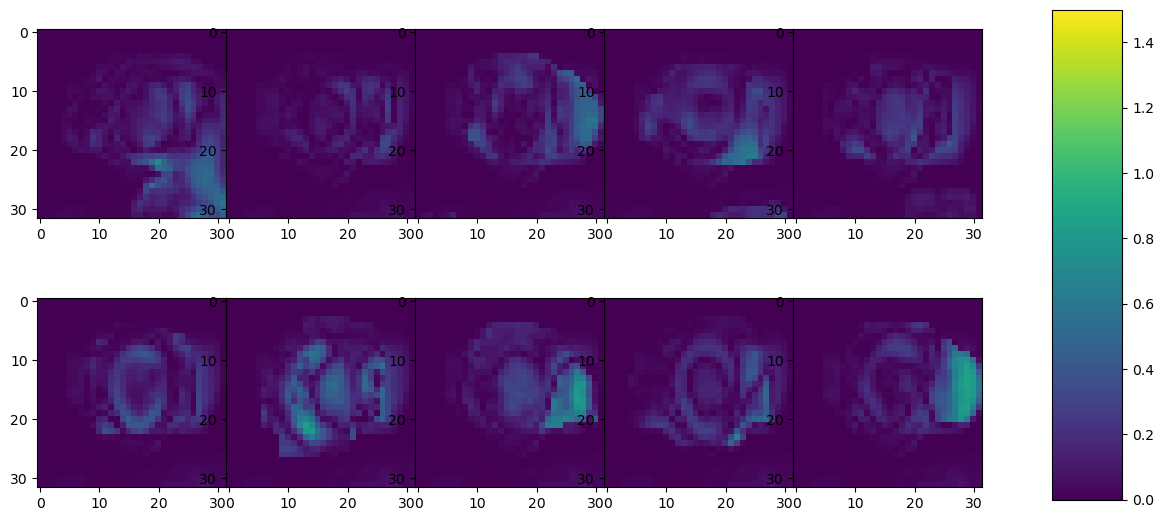

In [438]:
z = 32
#t = 0
c = 4
abs_diff_patient = np.abs(diff_patient)
abs_diff_control = np.abs(diff_control)

vmin = 0
vmax = 1.5
print('t =', t, 'z =', z, 'c =', c)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
im = axes[0,0].imshow(abs_diff_control[0+5, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,1].imshow(abs_diff_control[1+5, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,2].imshow(abs_diff_control[2+5, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,3].imshow(abs_diff_control[3+5, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[0,4].imshow(abs_diff_control[4+5, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,0].imshow(abs_diff_patient[0, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,1].imshow(abs_diff_patient[1, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,2].imshow(abs_diff_patient[2, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,3].imshow(abs_diff_patient[3, z, :,:,t,c], vmin = vmin, vmax = vmax)
im = axes[1,4].imshow(abs_diff_patient[4, z, :,:,t,c], vmin = vmin, vmax = vmax)
t +=1

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


#plt.colorbar()
plt.subplots_adjust(wspace=0, hspace=0)


Take the time at which for a particular slice the difference is the greatest 

In [80]:
# Pick time index with highest velocity mangitude
max_vx_c= abs(diff_control[...,1]).max(axis=(1,2,3))
max_vx_p = abs(diff_patient[...,1]).max(axis=(1,2,3))
max_vy_c= abs(diff_control[...,2]).max(axis=(1,2,3))
max_vy_p = abs(diff_patient[...,2]).max(axis=(1,2,3))
max_vz_c= abs(diff_control[...,3]).max(axis=(1,2,3))
max_vz_p = abs(diff_patient[...,3]).max(axis=(1,2,3))
max_mag_c= abs(diff_control[...,4]).max(axis=(1,2,3))
max_mag_p = abs(diff_patient[...,4]).max(axis=(1,2,3))
diff_control_t_max_vx = np.array([diff_control[i, :, :,:,max_vx_c.argmax(axis=1)[i],:] for i in range(diff_control.shape[0])])
diff_patient_t_max_vx = np.array([diff_patient[i, :, :,:,max_vx_p.argmax(axis=1)[i],:] for i in range(diff_patient.shape[0])])
diff_control_t_max_vy = np.array([diff_control[i, :, :,:,max_vy_c.argmax(axis=1)[i],:] for i in range(diff_control.shape[0])])
diff_patient_t_max_vy = np.array([diff_patient[i, :, :,:,max_vy_p.argmax(axis=1)[i],:] for i in range(diff_patient.shape[0])])
diff_control_t_max_vz = np.array([diff_control[i, :, :,:,max_vz_c.argmax(axis=1)[i],:] for i in range(diff_control.shape[0])])
diff_patient_t_max_vz = np.array([diff_patient[i, :, :,:,max_vz_p.argmax(axis=1)[i],:] for i in range(diff_patient.shape[0])])
diff_control_t_max_mag = np.array([diff_control[i, :, :,:,max_mag_c.argmax(axis=1)[i],:] for i in range(diff_control.shape[0])])
diff_patient_t_max_mag = np.array([diff_patient[i, :, :,:,max_mag_p.argmax(axis=1)[i],:] for i in range(diff_patient.shape[0])])
diff_control_t_max_vx.shape, diff_patient_t_max_vx.shape

((18, 64, 32, 32, 5), (5, 64, 32, 32, 5))

z = 23
Control on top, patient on bottom


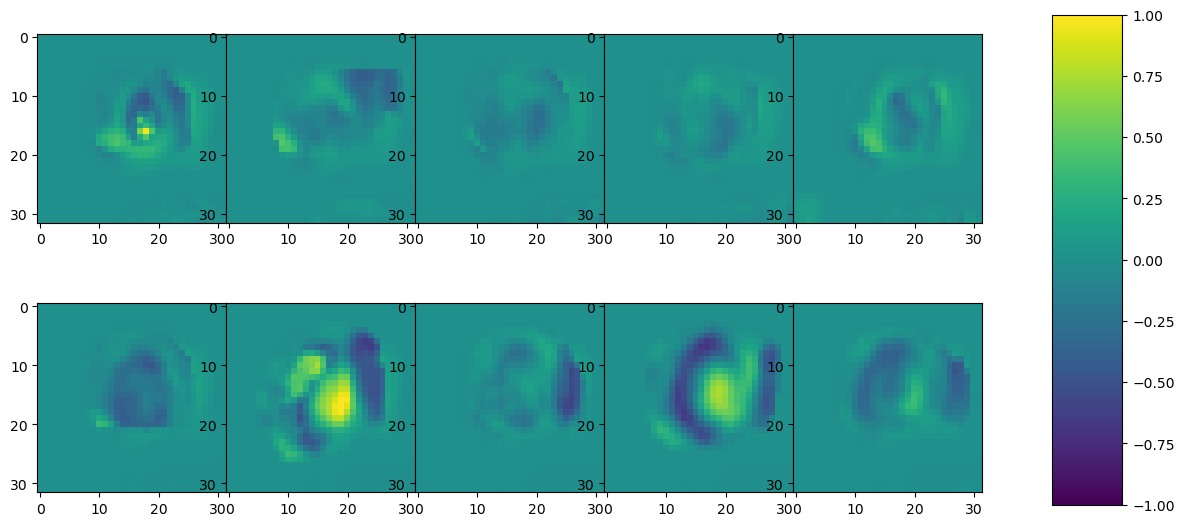

In [157]:
#z = 0
print('z =', z)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
im = axes[0,0].imshow(diff_control_t_max_vx[0, z, :,:,1], vmin = -1, vmax = 1)
im = axes[0,1].imshow(diff_control_t_max_vx[1, z, :,:,1], vmin = -1, vmax = 1)
im = axes[0,2].imshow(diff_control_t_max_vx[2, z, :,:,1], vmin = -1, vmax = 1)
im = axes[0,3].imshow(diff_control_t_max_vx[3, z, :,:,1], vmin = -1, vmax = 1)
im = axes[0,4].imshow(diff_control_t_max_vx[4, z, :,:,1], vmin = -1, vmax = 1)
im = axes[1,0].imshow(diff_patient_t_max_vx[0, z, :,:,1], vmin = -1, vmax = 1)
im = axes[1,1].imshow(diff_patient_t_max_vx[1, z, :,:,1], vmin = -1, vmax = 1)
im = axes[1,2].imshow(diff_patient_t_max_vx[2, z, :,:,1], vmin = -1, vmax = 1)
im = axes[1,3].imshow(diff_patient_t_max_vx[3, z, :,:,1], vmin = -1, vmax = 1)
im = axes[1,4].imshow(diff_patient_t_max_vx[4, z, :,:,1], vmin = -1, vmax = 1)


z+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


#plt.colorbar()
plt.subplots_adjust(wspace=0, hspace=0)
print('Control on top, patient on bottom')


z = 0
Control on top, patient on bottom


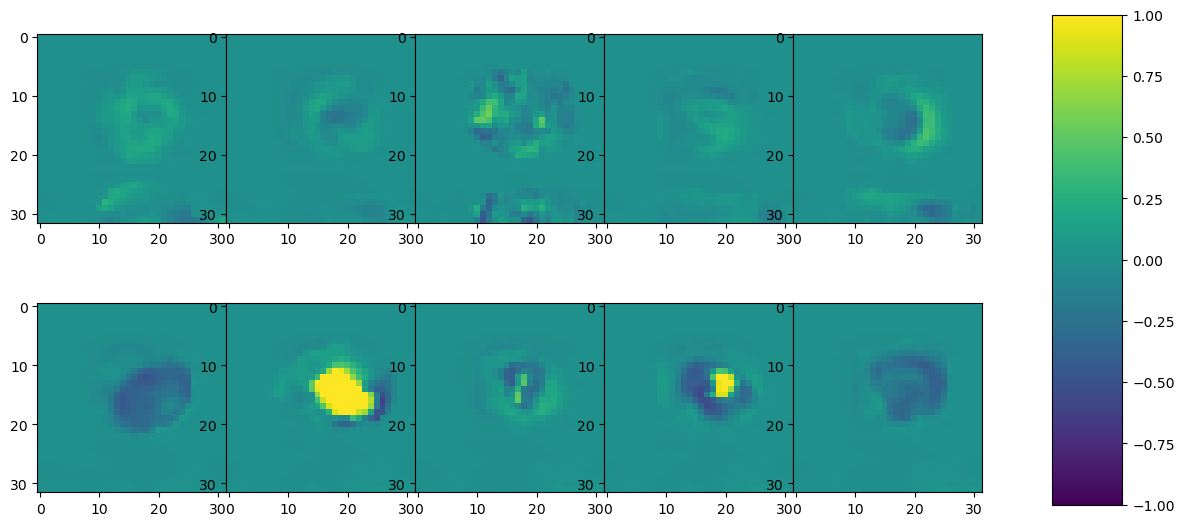

In [158]:
#z = 0
print('z =', z)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
im = axes[0,0].imshow(diff_control_t_max_vz[0, z, :,:,3], vmin = -1, vmax = 1)
im = axes[0,1].imshow(diff_control_t_max_vz[1, z, :,:,3], vmin = -1, vmax = 1)
im = axes[0,2].imshow(diff_control_t_max_vz[2, z, :,:,3], vmin = -1, vmax = 1)
im = axes[0,3].imshow(diff_control_t_max_vz[3, z, :,:,3], vmin = -1, vmax = 1)
im = axes[0,4].imshow(diff_control_t_max_vz[4, z, :,:,3], vmin = -1, vmax = 1)
im = axes[1,0].imshow(diff_patient_t_max_vz[0, z, :,:,3], vmin = -1, vmax = 1)
im = axes[1,1].imshow(diff_patient_t_max_vz[1, z, :,:,3], vmin = -1, vmax = 1)
im = axes[1,2].imshow(diff_patient_t_max_vz[2, z, :,:,3], vmin = -1, vmax = 1)
im = axes[1,3].imshow(diff_patient_t_max_vz[3, z, :,:,3], vmin = -1, vmax = 1)
im = axes[1,4].imshow(diff_patient_t_max_vz[4, z, :,:,3], vmin = -1, vmax = 1)


z+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


#plt.colorbar()
plt.subplots_adjust(wspace=0, hspace=0)
print('Control on top, patient on bottom')


z = 11
Control on top, patient on bottom


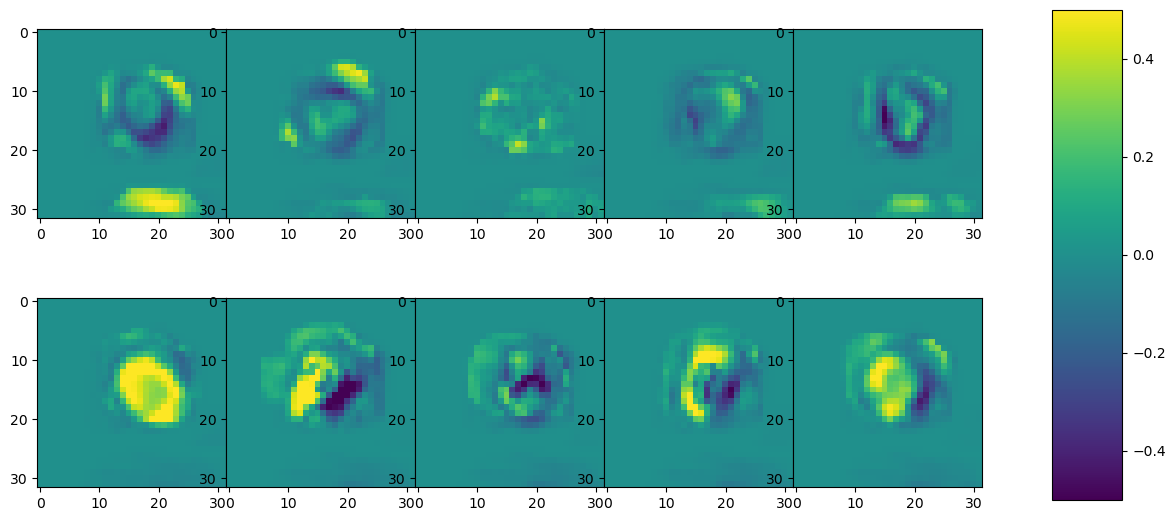

In [131]:
#z = 0
print('z =', z)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 7))
im = axes[0,0].imshow(diff_control_t_max_mag[0, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[0,1].imshow(diff_control_t_max_mag[1, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[0,2].imshow(diff_control_t_max_mag[2, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[0,3].imshow(diff_control_t_max_mag[3, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[0,4].imshow(diff_control_t_max_mag[4, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[1,0].imshow(diff_patient_t_max_mag[0, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[1,1].imshow(diff_patient_t_max_mag[1, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[1,2].imshow(diff_patient_t_max_mag[2, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[1,3].imshow(diff_patient_t_max_mag[3, z, :,:,4], vmin = -0.5, vmax = 0.5)
im = axes[1,4].imshow(diff_patient_t_max_mag[4, z, :,:,4], vmin = -0.5, vmax = 0.5)


z+=1
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)


#plt.colorbar()
plt.subplots_adjust(wspace=0, hspace=0)
print('Control on top, patient on bottom')


## Case 8

- Look at the standard deviations since it seems like the controls are more uniform than the patients
1. Take t = cause that's on average where the heart beats  
2. Take the time for each patient at which std is the highest for the magnitude velocity

(28, 64, 32, 32, 5) (5, 64, 32, 32, 5)


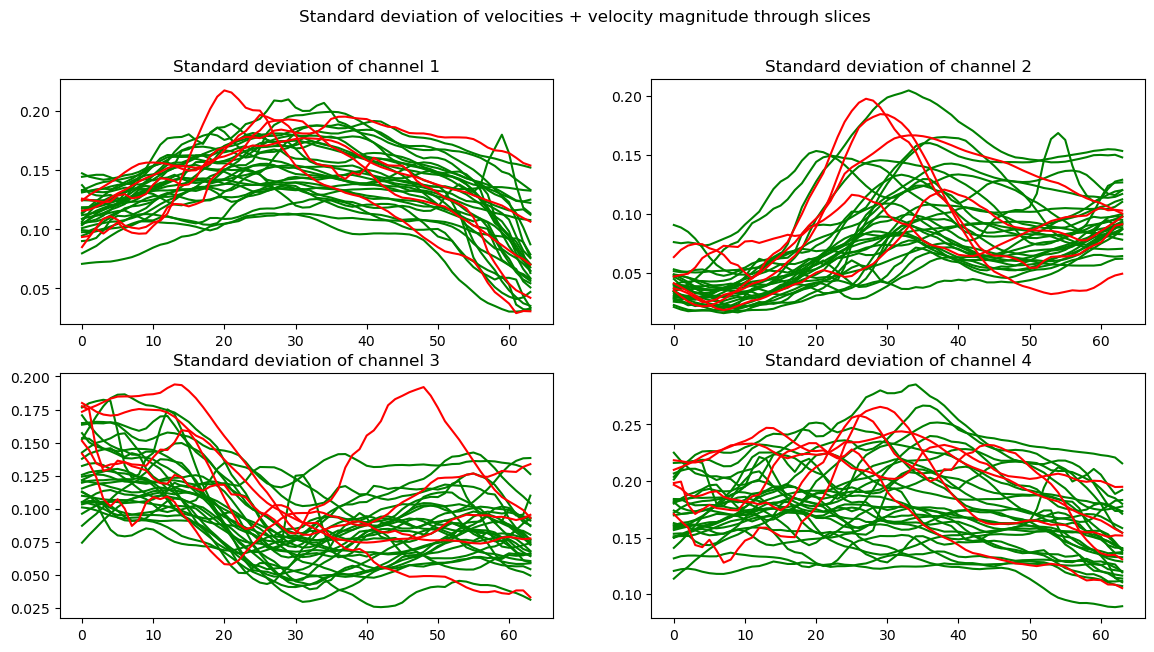

In [62]:
t = 4
control_time_constraint = control[...,t,:]
patient_time_constraint = patient[...,t,:]
print(control_time_constraint.shape, patient_time_constraint.shape)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
ax = axes.ravel()
fig.suptitle('Standard deviation of velocities + velocity magnitude through slices')
for i in range(4):
    ax[i].plot(control_time_constraint[...,i+1].std(axis=(2,3)).T, label='Controls', color = 'green');
    ax[i].plot(patient_time_constraint[...,i+1].std(axis=(2,3)).T, label='Patients', color = 'red');
    ax[i].set_title('Standard deviation of channel ' + str(i+1))


In [70]:
# Pick time index with highest velocity mangitude
max_magnitude_control_range = abs(control[...,4]).max(axis=(1,2,3))
max_magnitude_patient_range = abs(patient[...,4]).max(axis=(1,2,3))
print(max_magnitude_control_range.shape, max_magnitude_patient_range.shape)
print(max_magnitude_control_range.argmax(axis=1), max_magnitude_patient_range.argmax(axis=1))
control_t = np.array([control[i, :, :,:,max_magnitude_control_range.argmax(axis=1)[i],:] for i in range(control.shape[0])])
patient_t = np.array([patient[i, :, :,:,max_magnitude_patient_range.argmax(axis=1)[i],:] for i in range(patient.shape[0])])

print(control_t.shape, patient_t.shape)

(28, 48) (5, 48)
[3 3 4 3 4 4 3 3 4 3 2 4 3 3 3 3 3 3 4 4 3 4 3 3 4 3 3 3] [3 3 6 3 4]


(28, 64, 32, 32, 5) (5, 64, 32, 32, 5)


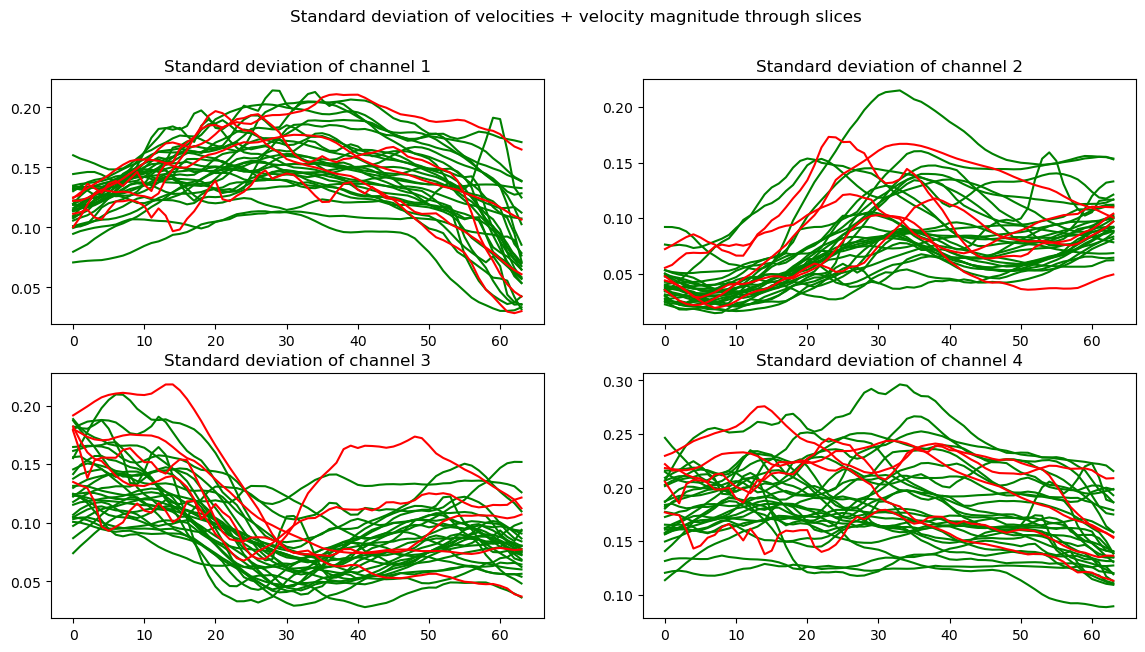

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 7))
ax = axes.ravel()
fig.suptitle('Standard deviation of velocities + velocity magnitude through slices')
for i in range(4):
    ax[i].plot(control_t[...,i+1].std(axis=(2,3)).T, label='Controls', color = 'green');
    ax[i].plot(patient_t[...,i+1].std(axis=(2,3)).T, label='Patients', color = 'red');
    ax[i].set_title('Standard deviation of channel ' + str(i+1))
